# Microsoft Malware detection

In this kernel, I build a LGBM model using only a subset of the training data, in order to fit in memory.

## Notebook  Content
1. [Utility functions](#0)
1. [Loading the data](#1) <br>
    2.1 [Get the files and select the variables](#2.1) <br>
    2.2 [Define the type of each variable](#2.2)
1. [Feature engineering](#2) <br>
    3.1 [Frequency encoding](#3.1) <br>
    3.2 [Label encoding](#3.2)
1. [Training the model](#3)
1. [Feature importance](#4)
1. [Submission](#5)

<a id="0"></a> <br>
## 1. Utility functions
Before starting, we define a utility function that helps managing memory.

In [1]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

<a id="1"></a> <br>
## 2. Loading the data

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import KFold
import warnings
import gc
import time
import sys
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn import metrics
# Plotly library
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
from plotly import tools
init_notebook_mode(connected=True)
pd.set_option('display.max_columns', 500)

<a id="2.1"></a> <br>
### 2.1 Get the files and select the variables
Following [Theo Viel](https://www.kaggle.com/theoviel/load-the-totality-of-the-data), we set the types of each fields in the train set in order to reduce the memory usage:

In [3]:
dtypes = {
        'MachineIdentifier':                                    'category',
        'ProductName':                                          'category',
        'EngineVersion':                                        'category',
        'AppVersion':                                           'category',
        'AvSigVersion':                                         'category',
        'IsBeta':                                               'int8',
        'RtpStateBitfield':                                     'float16',
        'IsSxsPassiveMode':                                     'int8',
        'DefaultBrowsersIdentifier':                            'float16',
        'AVProductStatesIdentifier':                            'float32',
        'AVProductsInstalled':                                  'float16',
        'AVProductsEnabled':                                    'float16',
        'HasTpm':                                               'int8',
        'CountryIdentifier':                                    'int16',
        'CityIdentifier':                                       'float32',
        'OrganizationIdentifier':                               'float16',
        'GeoNameIdentifier':                                    'float16',
        'LocaleEnglishNameIdentifier':                          'int8',
        'Platform':                                             'category',
        'Processor':                                            'category',
        'OsVer':                                                'category',
        'OsBuild':                                              'int16',
        'OsSuite':                                              'int16',
        'OsPlatformSubRelease':                                 'category',
        'OsBuildLab':                                           'category',
        'SkuEdition':                                           'category',
        'IsProtected':                                          'float16',
        'AutoSampleOptIn':                                      'int8',
        'PuaMode':                                              'category',
        'SMode':                                                'float16',
        'IeVerIdentifier':                                      'float16',
        'SmartScreen':                                          'category',
        'Firewall':                                             'float16',
        'UacLuaenable':                                         'float32',
        'Census_MDC2FormFactor':                                'category',
        'Census_DeviceFamily':                                  'category',
        'Census_OEMNameIdentifier':                             'float16',
        'Census_OEMModelIdentifier':                            'float32',
        'Census_ProcessorCoreCount':                            'float16',
        'Census_ProcessorManufacturerIdentifier':               'float16',
        'Census_ProcessorModelIdentifier':                      'float16',
        'Census_ProcessorClass':                                'category',
        'Census_PrimaryDiskTotalCapacity':                      'float32',
        'Census_PrimaryDiskTypeName':                           'category',
        'Census_SystemVolumeTotalCapacity':                     'float32',
        'Census_HasOpticalDiskDrive':                           'int8',
        'Census_TotalPhysicalRAM':                              'float32',
        'Census_ChassisTypeName':                               'category',
        'Census_InternalPrimaryDiagonalDisplaySizeInInches':    'float16',
        'Census_InternalPrimaryDisplayResolutionHorizontal':    'float16',
        'Census_InternalPrimaryDisplayResolutionVertical':      'float16',
        'Census_PowerPlatformRoleName':                         'category',
        'Census_InternalBatteryType':                           'category',
        'Census_InternalBatteryNumberOfCharges':                'float32',
        'Census_OSVersion':                                     'category',
        'Census_OSArchitecture':                                'category',
        'Census_OSBranch':                                      'category',
        'Census_OSBuildNumber':                                 'int16',
        'Census_OSBuildRevision':                               'int32',
        'Census_OSEdition':                                     'category',
        'Census_OSSkuName':                                     'category',
        'Census_OSInstallTypeName':                             'category',
        'Census_OSInstallLanguageIdentifier':                   'float16',
        'Census_OSUILocaleIdentifier':                          'int16',
        'Census_OSWUAutoUpdateOptionsName':                     'category',
        'Census_IsPortableOperatingSystem':                     'int8',
        'Census_GenuineStateName':                              'category',
        'Census_ActivationChannel':                             'category',
        'Census_IsFlightingInternal':                           'float16',
        'Census_IsFlightsDisabled':                             'float16',
        'Census_FlightRing':                                    'category',
        'Census_ThresholdOptIn':                                'float16',
        'Census_FirmwareManufacturerIdentifier':                'float16',
        'Census_FirmwareVersionIdentifier':                     'float32',
        'Census_IsSecureBootEnabled':                           'int8',
        'Census_IsWIMBootEnabled':                              'float16',
        'Census_IsVirtualDevice':                               'float16',
        'Census_IsTouchEnabled':                                'int8',
        'Census_IsPenCapable':                                  'int8',
        'Census_IsAlwaysOnAlwaysConnectedCapable':              'float16',
        'Wdft_IsGamer':                                         'float16',
        'Wdft_RegionIdentifier':                                'float16',
        'HasDetections':                                        'int8'
        }

First, we make a census of the variables, by type, and define the set we want to keep before reading the data:

In [4]:
numerics = ['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerical_columns = [c for c,v in dtypes.items() if v in numerics]
categorical_columns = [c for c,v in dtypes.items() if v not in numerics]

In [5]:
def add_noise(series, noise_level):
    return series * (1 + noise_level * np.random.randn(len(series)))

def target_encode(trn_series=None, 
                  tst_series=None, 
                  target=None, 
                  min_samples_leaf=1, 
                  smoothing=1,
                  noise_level=0):
    """
    Smoothing is computed like in the following paper by Daniele Micci-Barreca
    https://kaggle2.blob.core.windows.net/forum-message-attachments/225952/7441/high%20cardinality%20categoricals.pdf
    trn_series : training categorical feature as a pd.Series
    tst_series : test categorical feature as a pd.Series
    target : target data as a pd.Series
    min_samples_leaf (int) : minimum samples to take category average into account
    smoothing (int) : smoothing effect to balance categorical average vs prior  
    """ 
    assert len(trn_series) == len(target)
    assert trn_series.name == tst_series.name
    temp = pd.concat([trn_series, target], axis=1)
    # Compute target mean 
    averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])
    # Compute smoothing
    smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
    # Apply average function to all target data
    prior = target.mean()
    # The bigger the count the less full_avg is taken into account
    averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
    averages.drop(["mean", "count"], axis=1, inplace=True)
    # Apply averages to trn and tst series
    ft_trn_series = pd.merge(
        trn_series.to_frame(trn_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=trn_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_trn_series.index = trn_series.index 
    ft_tst_series = pd.merge(
        tst_series.to_frame(tst_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=tst_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_tst_series.index = tst_series.index
    return add_noise(ft_trn_series, noise_level), add_noise(ft_tst_series, noise_level)

We read the data, limiting the size of the training set to 4'000'000 rows:

In [6]:
nrows = 1000000
#_______________________________________________________________________________
retained_columns = numerical_columns + categorical_columns
train = pd.read_csv('train.csv',#nrows=nrows,
                    usecols = retained_columns,
                    dtype = dtypes)
#_______________________________________________________________
retained_columns += ['MachineIdentifier']
retained_columns.remove('HasDetections')


In [7]:
test = pd.read_csv('test.csv',#nrows=500000,
                   usecols = retained_columns,
                   dtype = dtypes)

In [8]:
target = train['HasDetections']
del train['HasDetections']

In [9]:
mean_encoded_variables = [
    'Census_OEMModelIdentifier',
    'CityIdentifier',
    'Census_FirmwareVersionIdentifier',
    'AvSigVersion',
    'Census_ProcessorModelIdentifier',
    'Census_OEMNameIdentifier',
    'CountryIdentifier',
    'AVProductStatesIdentifier',
    'DefaultBrowsersIdentifier',
    'Census_FirmwareManufacturerIdentifier',
    'Census_OSVersion',
    'OsBuildLab'
]

In [10]:
len(train),len(test)

(8921483, 7853253)

In [11]:
for column in mean_encoded_variables:
    trn, sub = target_encode(train[column], 
                             test[column], 
                             target=target, 
                             min_samples_leaf=100,
                             smoothing=10,
                             noise_level=0.01)
    train=pd.concat([train,trn],axis=1)
    test=pd.concat([test,sub],axis=1)

In [12]:
len(train),len(test)

(8921483, 7853253)

In [13]:
all=pd.concat([train, test])

In [14]:
(all.head())

,MachineIdentifier,ProductName,EngineVersion,AppVersion,AvSigVersion,IsBeta,RtpStateBitfield,IsSxsPassiveMode,DefaultBrowsersIdentifier,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,Platform,Processor,OsVer,OsBuild,OsSuite,OsPlatformSubRelease,OsBuildLab,SkuEdition,IsProtected,AutoSampleOptIn,PuaMode,SMode,IeVerIdentifier,SmartScreen,Firewall,UacLuaenable,Census_MDC2FormFactor,Census_DeviceFamily,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorManufacturerIdentifier,Census_ProcessorModelIdentifier,Census_ProcessorClass,Census_PrimaryDiskTotalCapacity,Census_PrimaryDiskTypeName,Census_SystemVolumeTotalCapacity,Census_HasOpticalDiskDrive,Census_TotalPhysicalRAM,Census_ChassisTypeName,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_PowerPlatformRoleName,Census_InternalBatteryType,Census_InternalBatteryNumberOfCharges,Census_OSVersion,Census_OSArchitecture,Census_OSBranch,Census_OSBuildNumber,Census_OSBuildRevision,Census_OSEdition,Census_OSSkuName,Census_OSInstallTypeName,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_OSWUAutoUpdateOptionsName,Census_IsPortableOperatingSystem,Census_GenuineStateName,Census_ActivationChannel,Census_IsFlightingInternal,Census_IsFlightsDisabled,Census_FlightRing,Census_ThresholdOptIn,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,Census_OEMModelIdentifier_mean,CityIdentifier_mean,Census_FirmwareVersionIdentifier_mean,AvSigVersion_mean,Census_ProcessorModelIdentifier_mean,Census_OEMNameIdentifier_mean,CountryIdentifier_mean,AVProductStatesIdentifier_mean,DefaultBrowsersIdentifier_mean,Census_FirmwareManufacturerIdentifier_mean,Census_OSVersion_mean,OsBuildLab_mean
0,0000028988387b115f69f31a3bf04f09,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1735.0,0,7.0,0,NaN,53447.0,1.0,1.0,1,29,128035.0,18.0,35.0,-85,windows10,x64,10.0.0.0,17134,256,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,1.0,0,NaN,0.0,137.0,NaN,1.0,1.0,Desktop,Windows.Desktop,2668.0,9124.0,4.0,5.0,2340.0,NaN,476940.0,HDD,299451.0,0,4096.0,Desktop,18.906250,1440.0,900.0,Desktop,NaN,4.294967e+09,10.0.17134.165,amd64,rs4_release,17134,165,Professional,PROFESSIONAL,UUPUpgrade,26.0,119,UNKNOWN,0,IS_GENUINE,Retail,NaN,0.0,Retail,NaN,628.0,36144.0,0,NaN,0.0,0,0,0.0,0.0,10.0,0.504194,0.510484,0.451024,0.590672,0.522693,0.499455,0.501619,0.555320,0.491952,0.496103,0.559397,0.530400
1,000007535c3f730efa9ea0b7ef1bd645,win8defender,1.1.14600.4,4.13.17134.1,1.263.48.0,0,7.0,0,NaN,53447.0,1.0,1.0,1,93,1482.0,18.0,119.0,64,windows10,x64,10.0.0.0,17134,256,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,1.0,0,NaN,0.0,137.0,NaN,1.0,1.0,Notebook,Windows.Desktop,2668.0,91656.0,4.0,5.0,2404.0,NaN,476940.0,HDD,102385.0,0,4096.0,Notebook,13.898438,1366.0,768.0,Mobile,NaN,1.000000e+00,10.0.17134.1,amd64,rs4_release,17134,1,Professional,PROFESSIONAL,IBSClean,8.0,31,UNKNOWN,0,OFFLINE,Retail,NaN,0.0,NOT_SET,NaN,628.0,57858.0,0,NaN,0.0,0,0,0.0,0.0,8.0,0.503034,0.501157,0.410303,0.467750,0.521213,0.507919,0.501391,0.559366,0.496258,0.508659,0.518054,0.534546
2,000007905a28d863f6d0d597892cd692,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1341.0,0,7.0,0,NaN,53447.0,1.0,1.0,1,86,153579.0,18.0,64.0,49,windows10,x64,10.0.0.0,17134,768,rs4,17134.1.amd64fre.rs4_release.180410-1804,Home,1.0,0,NaN,0.0,137.0,RequireAdmin,1.0,1.0,Desktop,Windows.Desktop,4908.0,317701.0,4.0,5.0,1972.0,NaN,114473.0,SSD,113907.0,0,4096.0,Desktop,21.500000,1920.0,1080.0,Desktop,NaN,4.294967e+09,10.0.17134.165,amd64,rs4_release,17134,165,Core,CORE,UUPUpgrade,7.0,30,FullAuto,0,IS_GENUI

<a id="2.2"></a> <br>
### 2.2 Define the type of each variable
In practice, among the numerical variables, many corresponds to identifiers. *In the current dataset, the truly numerical variables are in fact rare*. Below, I make a list of the variables which are truly numerical, according the the description of the data.

In [15]:
true_numerical_columns = [
    'Census_ProcessorCoreCount',
    'Census_PrimaryDiskTotalCapacity',
    'Census_SystemVolumeTotalCapacity',
    'Census_TotalPhysicalRAM',
    'Census_InternalPrimaryDiagonalDisplaySizeInInches',
    'Census_InternalPrimaryDisplayResolutionHorizontal',
    'Census_InternalPrimaryDisplayResolutionVertical',
    'Census_InternalBatteryNumberOfCharges'
]
for i in mean_encoded_variables:
    true_numerical_columns.append(i+"_mean")

We also list binary variables, since they can be treated as numericals by tree methods:

In [16]:
binary_variables = [c for c in all.columns[0:82] if all[c].nunique() == 2]

In [17]:
len(all.columns)

94

to finally make a census of the categorical variables:

In [18]:
categorical_columns = [c for c in all.columns 
                       if (c not in true_numerical_columns) & (c not in binary_variables)]

In [19]:
variables = {
    'categorical_columns': len(categorical_columns),
    'binary_variables': len(binary_variables),
    'true_numerical_columns': len(true_numerical_columns)
}
pie_trace = go.Pie(labels=list(variables.keys()), values=list(variables.values()))
layout = dict(title= "Variable types", height=400, width=800)
fig = dict(data=[pie_trace], layout=layout)
iplot(fig)

Most of the current variables are categories and we need to choose a method to treat them. **Depending on the cardinality of each variable**, we can opt for** one-hot-encoding, frequency or target encoding**. In the particular case of Light-GBM, we can also use the **built-in LGBM treatment of categoricals**:

In [20]:
cardinality = []
for c in categorical_columns:
    if c == 'MachineIdentifier': continue
    cardinality.append([c, all[c].nunique()])
cardinality.sort(key = lambda x:x[1], reverse=False)

trace = go.Bar(y=[x[0] for x in cardinality],
               x=[x[1] for x in cardinality],
               orientation='h', marker=dict(color='rgb(49,130,189)'), name='train')

layout = go.Layout(
    title='Categorical cardinality', height=1600, width=800,
    xaxis=dict(
        title='Number of categories',
        titlefont=dict(size=16, color='rgb(107, 107, 107)'),
        domain=[0.25, 1]
    ),
    barmode='group',
    bargap=0.1,
    bargroupgap=0.1
)

fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

<a id="2"></a> <br>
## 3. Feature Engineering
<a id="3.1"></a> <br>
### 3.1 Frequency encoding
For variables with large cardinality, an efficient encoding consists in ranking the categories with respect to their frequencies. These variables are then treated as numerical.

In [21]:
def frequency_encoding(variable):
    t = all[variable].value_counts().reset_index()
    t = t.reset_index()
    t.loc[t[variable] == 1, 'level_0'] = np.nan
    t.set_index('index', inplace=True)
    max_label = t['level_0'].max() + 1
    t.fillna(max_label, inplace=True)
    return t.to_dict()['level_0']

In [22]:
frequency_encoded_variables = [
    'Census_OEMModelIdentifier',
    'CityIdentifier',
    'Census_FirmwareVersionIdentifier',
    'AvSigVersion',
    'Census_ProcessorModelIdentifier',
    'Census_OEMNameIdentifier',
    'CountryIdentifier',
    'AVProductStatesIdentifier',
    'DefaultBrowsersIdentifier',
    'Census_FirmwareManufacturerIdentifier',
    'Census_OSVersion',
    'OsBuildLab'
]

In [23]:
for variable in tqdm(frequency_encoded_variables):
    
    freq_enc_dict = frequency_encoding(variable)
    all[variable] = all[variable].map(lambda x: freq_enc_dict.get(x, np.nan))
    #test[variable] = test[variable].map(lambda x: freq_enc_dict.get(x, np.nan))
    categorical_columns.remove(variable)

100%|██████████████████████████████████████████| 12/12 [01:59<00:00,  9.75s/it]


<a id="3.2"></a> <br>
### 3.2 Label encoding

In [24]:
all.head()

,MachineIdentifier,ProductName,EngineVersion,AppVersion,AvSigVersion,IsBeta,RtpStateBitfield,IsSxsPassiveMode,DefaultBrowsersIdentifier,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,Platform,Processor,OsVer,OsBuild,OsSuite,OsPlatformSubRelease,OsBuildLab,SkuEdition,IsProtected,AutoSampleOptIn,PuaMode,SMode,IeVerIdentifier,SmartScreen,Firewall,UacLuaenable,Census_MDC2FormFactor,Census_DeviceFamily,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorManufacturerIdentifier,Census_ProcessorModelIdentifier,Census_ProcessorClass,Census_PrimaryDiskTotalCapacity,Census_PrimaryDiskTypeName,Census_SystemVolumeTotalCapacity,Census_HasOpticalDiskDrive,Census_TotalPhysicalRAM,Census_ChassisTypeName,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_PowerPlatformRoleName,Census_InternalBatteryType,Census_InternalBatteryNumberOfCharges,Census_OSVersion,Census_OSArchitecture,Census_OSBranch,Census_OSBuildNumber,Census_OSBuildRevision,Census_OSEdition,Census_OSSkuName,Census_OSInstallTypeName,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_OSWUAutoUpdateOptionsName,Census_IsPortableOperatingSystem,Census_GenuineStateName,Census_ActivationChannel,Census_IsFlightingInternal,Census_IsFlightsDisabled,Census_FlightRing,Census_ThresholdOptIn,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,Census_OEMModelIdentifier_mean,CityIdentifier_mean,Census_FirmwareVersionIdentifier_mean,AvSigVersion_mean,Census_ProcessorModelIdentifier_mean,Census_OEMNameIdentifier_mean,CountryIdentifier_mean,AVProductStatesIdentifier_mean,DefaultBrowsersIdentifier_mean,Census_FirmwareManufacturerIdentifier_mean,Census_OSVersion_mean,OsBuildLab_mean
0,0000028988387b115f69f31a3bf04f09,win8defender,1.1.15100.1,4.18.1807.18075,134.0,0,7.0,0,NaN,0.0,1.0,1.0,1,1.0,205.0,18.0,35.0,-85,windows10,x64,10.0.0.0,17134,256,rs4,0.0,Pro,1.0,0,NaN,0.0,137.0,NaN,1.0,1.0,Desktop,Windows.Desktop,0.0,22022.0,4.0,5.0,135.0,NaN,476940.0,HDD,299451.0,0,4096.0,Desktop,18.906250,1440.0,900.0,Desktop,NaN,4.294967e+09,3.0,amd64,rs4_release,17134,165,Professional,PROFESSIONAL,UUPUpgrade,26.0,119,UNKNOWN,0,IS_GENUINE,Retail,NaN,0.0,Retail,NaN,1.0,2572.0,0,NaN,0.0,0,0,0.0,0.0,10.0,0.504194,0.510484,0.451024,0.590672,0.522693,0.499455,0.501619,0.555320,0.491952,0.496103,0.559397,0.530400
1,000007535c3f730efa9ea0b7ef1bd645,win8defender,1.1.14600.4,4.13.17134.1,0.0,0,7.0,0,NaN,0.0,1.0,1.0,1,4.0,171.0,18.0,119.0,64,windows10,x64,10.0.0.0,17134,256,rs4,0.0,Pro,1.0,0,NaN,0.0,137.0,NaN,1.0,1.0,Notebook,Windows.Desktop,0.0,118655.0,4.0,5.0,134.0,NaN,476940.0,HDD,102385.0,0,4096.0,Notebook,13.898438,1366.0,768.0,Mobile,NaN,1.000000e+00,19.0,amd64,rs4_release,17134,1,Professional,PROFESSIONAL,IBSClean,8.0,31,UNKNOWN,0,OFFLINE,Retail,NaN,0.0,NOT_SET,NaN,1.0,1415.0,0,NaN,0.0,0,0,0.0,0.0,8.0,0.503034,0.501157,0.410303,0.467750,0.521213,0.507919,0.501391,0.559366,0.496258,0.508659,0.518054,0.534546
2,000007905a28d863f6d0d597892cd692,win8defender,1.1.15100.1,4.18.1807.18075,336.0,0,7.0,0,NaN,0.0,1.0,1.0,1,55.0,673.0,18.0,64.0,49,windows10,x64,10.0.0.0,17134,768,rs4,0.0,Home,1.0,0,NaN,0.0,137.0,RequireAdmin,1.0,1.0,Desktop,Windows.Desktop,10.0,2.0,4.0,5.0,191.0,NaN,114473.0,SSD,113907.0,0,4096.0,Desktop,21.500000,1920.0,1080.0,Desktop,NaN,4.294967e+09,3.0,amd64,rs4_release,17134,165,Core,CORE,UUPUpgrade,7.0,30,FullAuto,0,IS_GENUINE,OEM:NONSLP,NaN,0.0,Retail,NaN,0.0,184.0,0,NaN,0.0,0,0,0.0,0.0,3.0,0.547200,0.520564,0.523310,0.532611,0.426288,0.529286,0.493853,0.562642,0.505125,0.510354,0.569824,0.536812
3,00000b11598a75ea8b

In [25]:
indexer = {}
for col in tqdm(categorical_columns):
    if col == 'MachineIdentifier': continue
    _, indexer[col] = pd.factorize(all[col])
    
for col in tqdm(categorical_columns):
    if col == 'MachineIdentifier': continue
    all[col] = indexer[col].get_indexer(all[col])
    #test[col] = indexer[col].get_indexer(test[col])

100%|██████████████████████████████████████████| 42/42 [38:24<00:00, 57.96s/it]


In [26]:
#all = reduce_mem_usage(all)
#test = reduce_mem_usage(test)

In [27]:
all.dtypes

MachineIdentifier                               object
ProductName                                      int64
EngineVersion                                    int64
AppVersion                                       int64
AvSigVersion                                   float64
IsBeta                                            int8
RtpStateBitfield                                 int64
IsSxsPassiveMode                                  int8
DefaultBrowsersIdentifier                      float64
AVProductStatesIdentifier                      float64
AVProductsInstalled                              int64
AVProductsEnabled                                int64
HasTpm                                            int8
CountryIdentifier                              float64
CityIdentifier                                 float64
OrganizationIdentifier                           int64
GeoNameIdentifier                                int64
LocaleEnglishNameIdentifier                      int64
Platform  

In [28]:
for column in all.columns[0:82]:
    if all[column].dtypes=='object':
        all[column]=all[column].astype('category')

In [29]:
train=all[0:len(train)]
test=all[len(train):len(all)]

In [30]:
len(all),len(train),len(test)

(16774736, 8921483, 7853253)

<a id="3"></a> <br>
## 3. Training the model

In [31]:
param = {'num_leaves': 60,
         'min_data_in_leaf': 60, 
         'objective':'binary',
         'max_depth': -1,
         'learning_rate': 0.1,
         "boosting": "gbdt",
         "feature_fraction": 0.8,
         "bagging_freq": 1,
         "bagging_fraction": 0.8 ,
         "bagging_seed": 11,
         "metric": 'auc',
         "lambda_l1": 0.1,
         "random_state": 133,
         "verbosity": -1}

We set the max number of iteration over folds:

In [32]:
max_iter = 5

In [33]:
folds = KFold(n_splits=5, shuffle=True, random_state=15)
oof = np.zeros(len(train))
categorical_columns = [c for c in categorical_columns if c not in ['MachineIdentifier']]
features = [c for c in train.columns if c not in ['MachineIdentifier']]
predictions = np.zeros(len(test))
start = time.time()
feature_importance_df = pd.DataFrame()
start_time= time.time()
score = [0 for _ in range(folds.n_splits)]

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features],
                           label=target.iloc[trn_idx],
                           categorical_feature = categorical_columns
                          )
    val_data = lgb.Dataset(train.iloc[val_idx][features],
                           label=target.iloc[val_idx],
                           categorical_feature = categorical_columns
                          )

    num_round = 10000
    clf = lgb.train(param,
                    trn_data,
                    num_round,
                    valid_sets = [trn_data, val_data],
                    verbose_eval=100,
                    early_stopping_rounds = 200)
    
    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance(importance_type='gain')
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    # we perform predictions by chunks
    initial_idx = 0
    chunk_size = 1000000
    current_pred = np.zeros(len(test))
    while initial_idx < test.shape[0]:
        final_idx = min(initial_idx + chunk_size, test.shape[0])
        idx = range(initial_idx, final_idx)
        current_pred[idx] = clf.predict(test.iloc[idx][features], num_iteration=clf.best_iteration)
        initial_idx = final_idx
    predictions += current_pred / min(folds.n_splits, max_iter)
   
    print("time elapsed: {:<5.2}s".format((time.time() - start_time) / 3600))
    score[fold_] = metrics.roc_auc_score(target.iloc[val_idx], oof[val_idx])
    if fold_ == max_iter - 1: break
        
if (folds.n_splits == max_iter):
    print("CV score: {:<8.5f}".format(metrics.roc_auc_score(target, oof)))
else:
     print("CV score: {:<8.5f}".format(sum(score) / max_iter))

fold n°0


D:\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning:

Using categorical_feature in Dataset.

D:\Anaconda3\lib\site-packages\lightgbm\basic.py:752: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.731932	valid_1's auc: 0.729542
[200]	training's auc: 0.739298	valid_1's auc: 0.734525
[300]	training's auc: 0.743315	valid_1's auc: 0.736442
[400]	training's auc: 0.74608	valid_1's auc: 0.737392
[500]	training's auc: 0.748332	valid_1's auc: 0.738003
[600]	training's auc: 0.750157	valid_1's auc: 0.738347
[700]	training's auc: 0.751677	valid_1's auc: 0.738536
[800]	training's auc: 0.753167	valid_1's auc: 0.738686
[900]	training's auc: 0.754499	valid_1's auc: 0.738784
[1000]	training's auc: 0.755812	valid_1's auc: 0.738899
[1100]	training's auc: 0.757028	valid_1's auc: 0.738933
[1200]	training's auc: 0.758305	valid_1's auc: 0.73907
[1300]	training's auc: 0.759469	valid_1's auc: 0.739164
[1400]	training's auc: 0.760524	valid_1's auc: 0.739173
[1500]	training's auc: 0.761574	valid_1's auc: 0.739196
[1600]	training's auc: 0.762563	valid_1's auc: 0.739191
[1700]	training's auc: 0.763524	valid_1's auc: 0.739

D:\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning:

Using categorical_feature in Dataset.

D:\Anaconda3\lib\site-packages\lightgbm\basic.py:752: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.731822	valid_1's auc: 0.729763
[200]	training's auc: 0.739166	valid_1's auc: 0.734823
[300]	training's auc: 0.743276	valid_1's auc: 0.736802
[400]	training's auc: 0.745994	valid_1's auc: 0.737716
[500]	training's auc: 0.74818	valid_1's auc: 0.738299
[600]	training's auc: 0.750044	valid_1's auc: 0.738631
[700]	training's auc: 0.751742	valid_1's auc: 0.738919
[800]	training's auc: 0.753285	valid_1's auc: 0.739148
[900]	training's auc: 0.754575	valid_1's auc: 0.739243
[1000]	training's auc: 0.755794	valid_1's auc: 0.739321
[1100]	training's auc: 0.757064	valid_1's auc: 0.73946
[1200]	training's auc: 0.75823	valid_1's auc: 0.739481
[1300]	training's auc: 0.759322	valid_1's auc: 0.73953
[1400]	training's auc: 0.760477	valid_1's auc: 0.739605
[1500]	training's auc: 0.761521	valid_1's auc: 0.73964
[1600]	training's auc: 0.762522	valid_1's auc: 0.739636
[1700]	training's auc: 0.76358	valid_1's auc: 0.739684


D:\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning:

Using categorical_feature in Dataset.

D:\Anaconda3\lib\site-packages\lightgbm\basic.py:752: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.731816	valid_1's auc: 0.729435
[200]	training's auc: 0.739138	valid_1's auc: 0.734502
[300]	training's auc: 0.743336	valid_1's auc: 0.736598
[400]	training's auc: 0.746168	valid_1's auc: 0.737664
[500]	training's auc: 0.748402	valid_1's auc: 0.738271
[600]	training's auc: 0.750387	valid_1's auc: 0.73872
[700]	training's auc: 0.751987	valid_1's auc: 0.738918
[800]	training's auc: 0.753522	valid_1's auc: 0.73909
[900]	training's auc: 0.754843	valid_1's auc: 0.739196
[1000]	training's auc: 0.756052	valid_1's auc: 0.739213
[1100]	training's auc: 0.757245	valid_1's auc: 0.739277
[1200]	training's auc: 0.758427	valid_1's auc: 0.739286
[1300]	training's auc: 0.759473	valid_1's auc: 0.739291
[1400]	training's auc: 0.760606	valid_1's auc: 0.739329
[1500]	training's auc: 0.761621	valid_1's auc: 0.739332
[1600]	training's auc: 0.762649	valid_1's auc: 0.739372
[1700]	training's auc: 0.763669	valid_1's auc: 0.739

D:\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning:

Using categorical_feature in Dataset.

D:\Anaconda3\lib\site-packages\lightgbm\basic.py:752: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.731688	valid_1's auc: 0.730389
[200]	training's auc: 0.738929	valid_1's auc: 0.735283
[300]	training's auc: 0.742992	valid_1's auc: 0.737296
[400]	training's auc: 0.745789	valid_1's auc: 0.738196
[500]	training's auc: 0.747947	valid_1's auc: 0.73871
[600]	training's auc: 0.749878	valid_1's auc: 0.73917
[700]	training's auc: 0.751604	valid_1's auc: 0.739488
[800]	training's auc: 0.753044	valid_1's auc: 0.739628
[900]	training's auc: 0.754461	valid_1's auc: 0.739798
[1000]	training's auc: 0.755762	valid_1's auc: 0.739954
[1100]	training's auc: 0.756998	valid_1's auc: 0.740048
[1200]	training's auc: 0.758166	valid_1's auc: 0.740087
[1300]	training's auc: 0.759308	valid_1's auc: 0.740131
[1400]	training's auc: 0.760312	valid_1's auc: 0.740136
[1500]	training's auc: 0.761359	valid_1's auc: 0.740138
Early stopping, best iteration is:
[1348]	training's auc: 0.759809	valid_1's auc: 0.740156
time elapsed: 6.9

D:\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning:

Using categorical_feature in Dataset.

D:\Anaconda3\lib\site-packages\lightgbm\basic.py:752: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.731923	valid_1's auc: 0.729153
[200]	training's auc: 0.739168	valid_1's auc: 0.73406
[300]	training's auc: 0.743258	valid_1's auc: 0.736024
[400]	training's auc: 0.746175	valid_1's auc: 0.737172
[500]	training's auc: 0.748458	valid_1's auc: 0.737853
[600]	training's auc: 0.750256	valid_1's auc: 0.738176
[700]	training's auc: 0.751914	valid_1's auc: 0.738428
[800]	training's auc: 0.753425	valid_1's auc: 0.738584
[900]	training's auc: 0.754822	valid_1's auc: 0.738726
[1000]	training's auc: 0.756077	valid_1's auc: 0.738775
[1100]	training's auc: 0.757321	valid_1's auc: 0.738876
[1200]	training's auc: 0.758452	valid_1's auc: 0.738911
[1300]	training's auc: 0.75957	valid_1's auc: 0.738972
[1400]	training's auc: 0.760671	valid_1's auc: 0.739046
[1500]	training's auc: 0.761714	valid_1's auc: 0.739071
[1600]	training's auc: 0.76283	valid_1's auc: 0.739189
[1700]	training's auc: 0.763846	valid_1's auc: 0.7392

<a id="4"></a> <br>
## 4. Feature importance

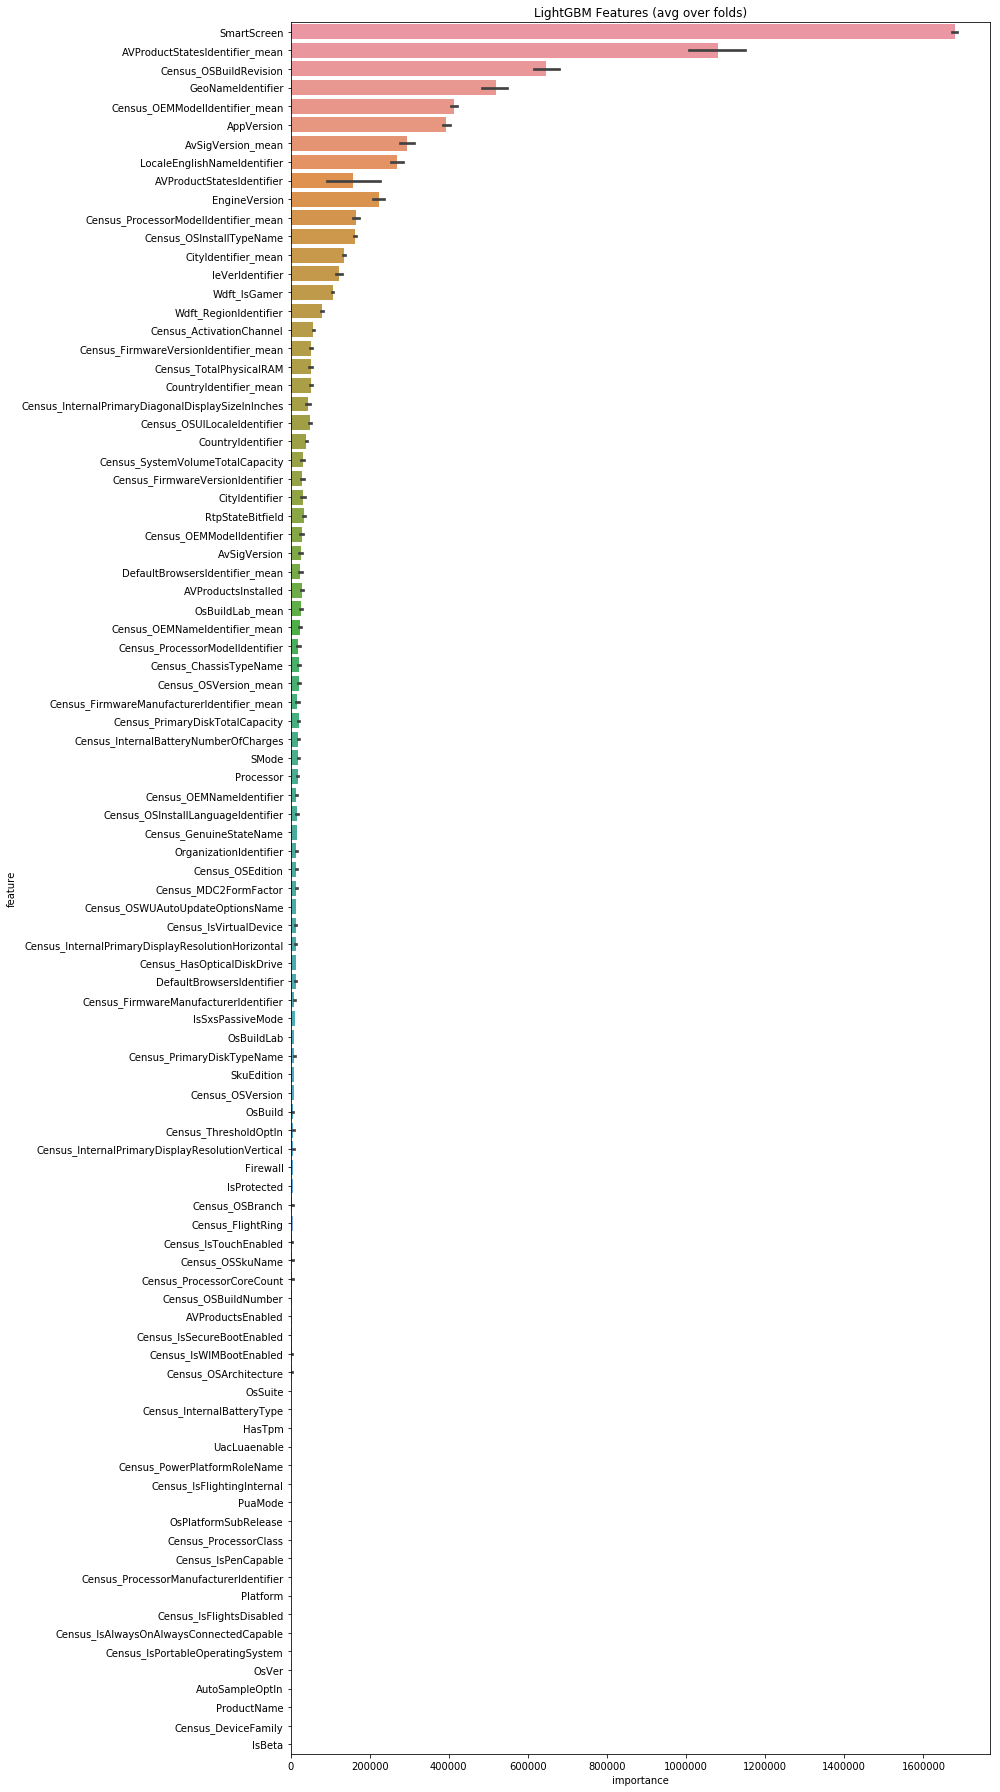

In [34]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

<a id="5"></a> <br>
## 5. Submission

In [35]:
sub_df = pd.DataFrame({"MachineIdentifier": test["MachineIdentifier"].values})
print(len(sub_df))
sub_df["HasDetections"] = predictions

7853253


In [36]:
len(sub_df["HasDetections"])

7853253

In [37]:
from datetime import datetime as dt
score=metrics.roc_auc_score(target, oof)
filename = 'subm_{:.6f}meanencodidng{}_{}.csv'.format(score, 'Feature_Encoding_LGBM', dt.now().strftime('%Y-%m-%d-%H-%M'))
sub_df.to_csv(filename, index=False)